# CS522 - Final Project
The objective of the final project is to integrate various machine learning techniques to achieve the best performance. Final project is a group effort. Each group can have 4-5 members. You are required to apply ALL techniques learned in this semester.

## Schedule
- (5) Milestone 1 (Due 11/4): Group Formation and Topic selection. Submit through Canvas. Approval and comments will be returned in one day. The same topic cannot be chosen by more than 1 group. The topic follows the first-come first-served rule. So pick a topic as soon as possible.
- (5) Milestone 2 - Literature Survey (Due 11/11): Background study including references and state-of-the-art performance on the dataset (2-page report need to be submitted).
- (5) Milestone 3 - Prototype 1 (Due 11/18): Prototype, preliminary results and task allocation among group members. Apply at least one learned technique successfully for each component in the pipeline on the chosen dataset and submit a 1-page report.
- (5) Milestone 4 - Prototype 2 (Due 12/02): Implement at least two solutions to each component of the pipeline. Determine what metrics to use. Provide performance evaluation results.
- (100) Final presentation (Due 12/08)(Presentation slides due the midnight before the presentation on 12/9. Submit through Canvas)
- (80) Final report (Due 12/10). Submit through Canvas.

## Potential Topics
Each group can choose one topic from the following sources. All selection needs to be approved by instructor.
- KDD-Cup 1997-2009
- Kaggle Competitions
- Other topics: You can select a topic yourself from other resources.

## Requirement
General steps involved in a machine learning problem include
- Data collection (raw data)
- Feature extraction (how to extract features from the raw data)
- Feature selection (dimensionality reduction - Fisher's linear discriminant or PCA)
- Classification/Regression methods need to be included
    - Supervised learning and Unsupervised learning
    - Baysian approaches and non-Baysian approaches
    - Parametric and Non-parametric density estimation in supervised learning
    - Fusion
- Performance evaluation
- Feedback system

You are required to evaluate the effect of various aspects of the classification/regression process, including but not limited to
- the effect of assuming the data is Gaussian-distributed
- the effect of assuming parametric pdf vs. non-parametric pdf
- the effect of using different prior probability ratio
- the effect of using different distance
- the effect of knowing the class label
- the effect of dimension of the feature space (e.g., changed through dimensionality reduction)
- the effect of fusion

To be more specific, you need to at least go through the following steps:
- Data normalization
- Dimensionality reduction
    - Classification/Regression with the following
    - MPP (case 1, 2, and 3)
    - kNN with different k's
    - BPNN
    - Decision tree
    - SVM
    - Clustering (kmeans, wta)
- Classifier fusion
- Evaluation (use n-fold cross validation to generate confusion matrix and ROC curve if applicable).

# 1. Data collection (raw data) - Face Mask 12k Images Dataset
- URL: [https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset](https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset)

This dataset is used for Face Mask Detection Classification with images. The dataset consists of almost 12K images which are almost 328.92MB in size.

"All the images with the face mask (~6K) are scrapped from google search and all the images without the face mask are preprocessed from the CelebFace dataset created by Jessica Li (https://www.kaggle.com/jessicali9530). Thank you so much Jessica for providing a wonderful dataset to the community."


In [18]:
%load_ext autoreload
%autoreload 2

import os
import PIL
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from convolution import *
from activation_functions import get_activation_func

## 1.1. Read In Data
Throughout this project:
- 0 corresponds to not wearing a mask
- 1 corresponds to wearing a mask

In [80]:
# make directory to save generated images to
os.makedirs('img', exist_ok=True)



dataset_dir = os.path.join("datasets", "face_mask")
def get_dataset_fn(dataset_dir: str, type: str) -> (np.array, np.array):
    """
    given the directory name of the entire dataset and whether it is the train, validation, or test set
    return X and y where X is a list of filenames and y is the target labels
    """
    # get base dir path (account for different operating systems)
    base_dir = os.path.join(dataset_dir, type)
    # get directories for each class in each folder
    no_mask_dir = os.path.join(base_dir, "WithoutMask")
    mask_dir = os.path.join(base_dir, "WithMask")
    # get filenames
    no_mask_fn = list(map(lambda fn: os.path.join(no_mask_dir,fn),os.listdir(no_mask_dir)))
    mask_fn = list(map(lambda fn: os.path.join(mask_dir,fn), os.listdir(mask_dir)))
    # create X with associated y labels
    y = np.hstack((np.zeros(len(no_mask_fn)),np.ones(len(mask_fn))))
    X = np.hstack((np.array(no_mask_fn),np.array(mask_fn)))
    return X, y

def load_img(fn: str) -> np.array:
    """
    load an image into a numpy array from the given filename
    # converts to grayscale
    """
    return np.array(Image.open(fn))

def load_dataset(X_fn: np.array) -> list:
    """
    given a list of filenames, load in each image into a numpy array and return a list of the images
    """
    X = []
    # iterate through each filename and load in each image
    for i in range(len(X_fn)):
        X.append(load_img(X_fn[i]))

    # returns X as a list because images are different sizes
    return X

def to_categorical(y) -> np.array:
    """
    One hot encode the target labels
    """
    Y = np.zeros((len(y),len(np.unique(y))))
    for i in range(len(y)):
        Y[i,int(y[i])] = 1
    return Y

# get dataset of filenames and labels
X_train_fn, y_train = get_dataset_fn(dataset_dir, "train")
X_validation_fn, y_validation = get_dataset_fn(dataset_dir, "validation")
X_test_fn, y_test = get_dataset_fn(dataset_dir, "test")

# one hot encode target labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_validation = to_categorical(y_validation)

# load in images
X_train = load_dataset(X_train_fn)
X_validation = load_dataset(X_validation_fn)
X_test = load_dataset(X_test_fn)


## 1.2. Normalizing dataset
Need to standardize the size of the images.
It is conventional to resize all of the images to the smallest image in the dataset.
https://datascience.stackexchange.com/questions/40462/how-to-prepare-the-varied-size-input-in-cnn-prediction



In [22]:
# helper functions to resize images
def resize_img(x:np.array, size: tuple):
    return np.asarray(Image.fromarray(x).resize(size, resample=PIL.Image.LANCZOS)).astype(np.uint8)
def resize_dataset(X, size:tuple):
    X_new = np.zeros((len(X), *size))
    size = size[:-1] if len(size) == 3 else size
    for i, x in enumerate(X):
        X_new[i] = resize_img(x, size)
    return X_new

# helper functions to turn images to grayscale
def img2grayscale(img: np.array):
    return np.asarray(ImageOps.grayscale(Image.fromarray(img.astype(np.uint8),'RGB'))).astype(np.uint8)
def dataset2grayscale(X):
    X_new = []
    for  x in X:
        X_new.append(img2grayscale(x))
    return X_new

# resize training data
size = (128,128,3)
X_train_resized = resize_dataset(X_train, size)
X_validation_resized = resize_dataset(X_validation, size)
X_test_resized = resize_dataset(X_test, size)

# create a set of grayscale training data
X_train_gray = dataset2grayscale(X_train_resized)
X_validation_gray = dataset2grayscale(X_validation_resized)
X_test_gray = dataset2grayscale(X_test_resized)

# min-max scale images
def min_max_scale_img(x:np.array):
    x = x.astype("float64")
    x /= 255
    return x
def min_max_scale_dataset(X):
    X_new = []
    for x in X:
        X_new.append(min_max_scale_img(x))
    return X_new

# normalize both the rgb and grayscale data
# RGB
X_train_norm = min_max_scale_dataset(X_train_resized)
X_validation_norm = min_max_scale_dataset(X_validation_resized)
X_test_norm = min_max_scale_dataset(X_test_resized)
# Gray Variation
X_train_gray_norm = min_max_scale_dataset(X_train_gray)
X_validation_gray_norm = min_max_scale_dataset(X_validation_gray)
X_test_gray_norm = min_max_scale_dataset(X_test_gray)


## 1.3. Peek at Dataset
In order to get a feel for the data, lets look at some of the images

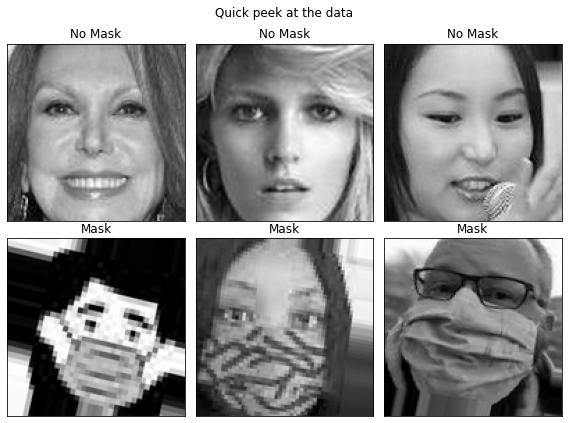

In [10]:
def plot_img_grid(img, label, size, pos):
    """
    given the image, its label, the size of the grid, and its position on the grid,
    create a grid of images displaying images in the dataset
    """
    ax = plt.subplot2grid(size, pos)
    ax.tick_params(left = False, right = False , labelleft = False ,
                   labelbottom = False, bottom = False)
    ax.title.set_text(label)
    ax.imshow(img,cmap='gray')

fig = plt.figure(figsize=(8,6))
fig.suptitle('Quick peek at the data')
plot_img_grid(X_train_gray_norm[0], 'No Mask', (2,3),(0,0))
plot_img_grid(X_train_gray_norm[1000], 'No Mask', (2,3),(0,1))
plot_img_grid(X_train_gray_norm[2000], 'No Mask', (2,3),(0,2))
plot_img_grid(X_train_gray_norm[7000], 'Mask', (2,3),(1,0))
plot_img_grid(X_train_gray_norm[8001], 'Mask', (2,3),(1,1))
plot_img_grid(X_train_gray_norm[9004], 'Mask', (2,3),(1,2))
plt.tight_layout()
plt.savefig('./img/faces.png', dpi=500)
plt.show()


# 2. Feature extraction
Objective: how to extract features from the raw data

# 2.1. Convolutional Neural Network (CNN)

![CNN Hierarchy](img/cnn_hierarchy.png)

Build Layers and Sequential Model for the convolution


Model: Sequential

#    Layer
0    input_layer (Conv3d)
1    activation (Activation)
2    pooling1 (MaxPooling2D)
3    layer1 (Conv3d)
4    activation (Activation)
5    pooling1 (MaxPooling2D)


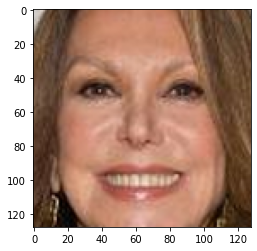

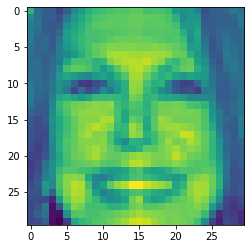

In [23]:
kernel = np.array([ [[1,-1,1], [-1, 8, -1], [1,-1,1]], [[1,-1,1], [-1, 8, -1], [1,-1,1]], [[1,-1,1], [-1, 8, -1], [1,-1,1]] ]) # 3d kernel needed for 3d image

model = Sequential()
model.add(Conv(kernel=kernel, name="input_layer"))
model.add(Activation('relu'))
model.add(Pooling2D(pool_size=2, stride=2, padding=0, mode='avg', name="pooling1"))
model.add(Conv(kernel=kernel, name="layer1"))
model.add(Activation('relu'))
model.add(Pooling2D(pool_size=2, stride=2, padding=0, mode='avg', name="pooling1"))
model.summary()

x = model.feedforward(X_train_norm[0])

# display original image
plt.imshow(X_train_norm[0])
plt.show()

# display convolved image
plt.imshow(x)
plt.show()

Model: Sequential

#    Layer
0    input_layer (Conv2d)
1    activation (Activation)
2    pooling_2d (MaxPooling2D)
3    input_layer (Conv2d)
4    activation (Activation)
5    input_layer (Conv2d)


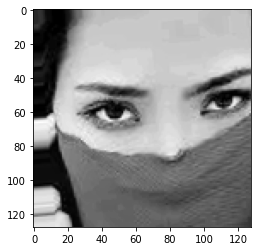

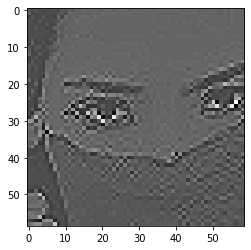

In [24]:
# convolution kernel
# kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]) # sharper images
kernel = np.array([[0, -1, 0], [-1, 6, -1], [0, -1, 0]]) # sharper images
# kernel = np.array([[-1, -1, -1], [-1, 0, -1], [-1, -1, -1]])
# kernel = np.array([[[-1, 0, -1], [-1, 0, -1], [-1, 0, -1]],
#                    [[-1, 0, -1], [-1, 0, -1], [-1, 0, -1]],
#                    [[-1, 0, -1], [-1, 0, -1], [-1, 0, -1]]])
# kernel = np.array([[0,1,2,1,0], [1,4,8,4,1], [2,8,16,8,2], [1,4,8,4,1],[0,1,2,1,0]]) # smoothing
# kernel = np.array([[0, 1, 0], [1, 4, 1], [0, 1, 0]])  # gaussian blur

# build model
model = Sequential()
model.add(Conv(kernel=kernel, name="input_layer"))
model.add(Activation('relu'))
model.add(Pooling2D(mode='avg'))
model.add(Conv(kernel=kernel, name="input_layer"))
model.add(Activation('relu'))
model.add(Conv(kernel=kernel, name="input_layer"))
# model.add(Activation('sigmoid'))
model.summary()

# feed image through model
x = model.feedforward(X_train_gray_norm[7345])

# display original image
plt.imshow(X_train_gray_norm[7345],cmap='gray')
plt.show()

# display convoluted image
plt.imshow(x,cmap='gray')
plt.show()

# 3. Feature Selection
Dimensionality Reduction - Fisher's linear discriminant or PCA

In [28]:
print("# Train")
X_train_norm = np.array(X_train_norm)
X_train_gray_norm = np.array(X_train_gray_norm)
print(f"* X_train_norm shape {X_train_norm.shape}")
print(f"* X_train_gray_norm shape {X_train_gray_norm.shape}")
print(f"* y_train shape {y_train.shape}")
print()

print("# Validation")
X_validation_norm = np.array(X_validation_norm)
X_validation_gray_norm = np.array(X_validation_gray_norm)
print(f"* X_validation_norm shape {X_validation_norm.shape}")
print(f"* X_validation_gray_norm shape {X_validation_gray_norm.shape}")
print(f"* y_validation shape {y_validation.shape}")
print()

print("# Test")
X_test_norm = np.array(X_test_norm)
X_test_gray_norm = np.array(X_test_gray_norm)
print(f"* X_test_norm shape {X_test_norm.shape}")
print(f"* X_test_gray_norm shape {X_test_gray_norm.shape}")
print(f"* y_test shape {y_test.shape}")
print()

# Flatten array (without CNN for now until we run and save all images)

# Train
* X_train_norm shape (10000, 128, 128, 3)
* X_train_gray_norm shape (10000, 128, 128)
* y_train shape (10000, 2)

# Validation
* X_validation_norm shape (800, 128, 128, 3)
* X_validation_gray_norm shape (800, 128, 128)
* y_validation shape (800, 2)

# Test
* X_test_norm shape (992, 128, 128, 3)
* X_test_gray_norm shape (992, 128, 128)
* y_test shape (992, 2)



In [12]:
# this might take a while
# save the output of the convoluted training examples in case we want to use them later
dir_path = os.path.join('datasets','face_mask_pickled')
os.makedirs(dir_path, exist_ok=True)

def get_conv_dataset(dataset, fn):
    if os.path.exists(fn):
        with open(fn, 'rb') as f:
            conv = pickle.load(f)
    else:
        conv = np.array([model.feedforward(x) for x in dataset])
        with open(fn, 'wb') as f:
            pickle.dump(conv, f)
    return conv
X_train_gray_conv = get_conv_dataset(X_train_gray_norm, os.path.join(dir_path, 'X_train_gray_conv.pkl'))
X_validation_gray_conv = get_conv_dataset(X_validation_gray_norm, os.path.join(dir_path, 'X_validation_gray_conv.pkl'))
X_test_gray_conv = get_conv_dataset(X_test_gray_norm, os.path.join(dir_path, 'X_test_gray_conv.pkl'))

# 4. Classification/Regression methods need to be included
- Supervised learning and Unsupervised learning
- Baysian approaches and non-Baysian approaches
- Parametric and Non-parametric density estimation in supervised learning
- Fusion

Classification performed with:
1. MPP (case 1, 2, and 3)
2. kNN with different k's
3. BPNN
4. Decision tree
5. SVM
6. Clustering (kmeans, wta)

You are required to evaluate the effect of various aspects of the classification/regression process, including but not limited to:
- the effect of assuming the data is Gaussian-distributed
- the effect of assuming parametric pdf vs. non-parametric pdf
- the effect of using different prior probability ratio
- the effect of using different distance
- the effect of knowing the class label
- the effect of dimension of the feature space (e.g., changed through dimensionality reduction)
- the effect of fusion

## 4.1. MPP (case 1, 2, and 3)

## 4.2. kNN with different k's

## 4.3. BPNN

In [13]:
from bpnn import BPNN

print(x.shape)
# model_BPNN = BPNN()

(59, 59)


## 4.4. Decision Tree

## 4.5. SVM

## 4.6. Clustering (KMeans and WTA)

In [ ]:
from kmeans import kmeans_image_compress, kmeans_classify
from data_functions import get_dataset_fn, load_dataset, resize_dataset, to_categorical
import numpy as np

# plt.imshow(X_train[0])
# plt.show()

# plt.imshow(kmeans_image_compress(X_train[0], 3))
# plt.show()
dataset_dir = os.path.join("datasets", "face_mask")
size = (128, 128, 3)

X_train_fn, y_train = get_dataset_fn(dataset_dir, "train")
X_train = load_dataset(X_train_fn)
y_train = y_train.astype(int)
X_train_resized = resize_dataset(X_train, size)

# mean_0 = np.mean(X_train_resized[y_train == 0], axis=0).astype(int)
# mean_1 = np.mean(X_train_resized[y_train == 1], axis=0).astype(int)

# plt.imshow(mean_0)
# plt.show()

# plt.imshow(mean_1)
# plt.show()

means = kmeans_classify(X_train_resized, 2, 0.0).astype(int)

plt.imshow(means[0])
plt.show()

plt.imshow(means[1])
plt.show()

Error: Session cannot generate requests

# 5. Performance evaluation
Note: Use n-fold cross validation to generate confusion matrix and ROC curve if applicable.

# 6. Feedback system
Maybe